In [1]:

import torch
import torch.nn as nn
import random
import torch.optim as optim
import numpy as np
from collections import deque
import sys
sys.path.append('/content/sample_data/')  # Ajouter le chemin du fichier au chemin de recherche de Python
import demplacement_aleatoire_Test_Nicolas
from demplacement_aleatoire_Test_Nicolas import *
import math
from pathlib import Path


pygame 2.6.0 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
device = "cpu"

print(device)
torch.device(device)

cpu


device(type='cpu')

In [3]:
class Deep_Q_Network(nn.Module):
    def __init__(self,input_dim,fc1_dim,fc2_dim,n_action):
        super().__init__()
        
        self.input_dim = input_dim
        self.n_action = n_action
        self.fc1_dim = fc1_dim
        self.fc2_dim = fc2_dim

        #Layer
        self.layer1 = nn.Linear(self.input_dim, self.fc1_dim)
        self.layer2 = nn.Linear(self.fc1_dim, self.fc2_dim)
        self.layer3 = nn.Linear(self.fc2_dim,n_action)
        self.relu  = nn.ReLU()


    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

    def act(self,pos):
        pos_t = torch.as_tensor(pos, dtype = torch.float32).to(device)
        q_values = self(pos_t.unsqueeze(0))

        max_q_index = torch.argmax(q_values, dim = 1)[0]
        action = max_q_index.detach().item()

        return action
    



In [4]:

Gamma =0.99
Batch_Size = 32 # the number of transition to the replay
Buffer_Size = 50_000 # Max of transition before override
Min_Replay_Size = 1000 # number transition the replay buffer
nbEpisdes = 25_001
epsilon = 1.0
Epsilon_End = 0.001
Epsilon_Decay = 1/nbEpisdes


 # Epsilon calculation for Epsilon Greedy Strategy with sigmoid function
def epsilonFromSigmoid(currentEpisode, maxEpisode):
    x = currentEpisode - maxEpisode/2.5
    l = 1/(maxEpisode/20)
    return 1 / (1 + math.exp(-l*x))


# Initialize the environment

In [5]:

mapp = np.array([
    "FFFFFFFFFFFFFFFF",
    "FFFFFFFFFFFFFFFF",
    "FFFFFFFFFFFFFFFF",
    "FFFFFFFHFFFHFFFF",
    "FFSFFFHFFFSFFFFF",
    "FFFFFFFFFFFHFFFF",
    "FFFFFFFFHFFFFFFF",
    "FFFFFFFFFFFFHFFF",
    "FFFHSFFFFHFFSFFF",
    "FFFHFFHFFHFFSFFF",
    "FFFFFHFFFFFFFHFF",
    "FFFFFFFFFFFFHFFF",
    "FFFFFFFFFHFFFFFF",
    "FFFHSFFFFFFSFFFF",
    "FFFFFFFFFHFFFFHF",
    "FFFFFFGFFFFFFFFF"
])

# Create an environment with the map and two agents
env = Environment(mapp,16, 8)

# Creation des agents avec des positions initiales aleatoires
#agents = [Agent(np.random.randint(env.size_map**2), np.random.randint(5), 0, False) for _ in range(env.number_agent)]

agents = [Agent(18+20,0,0, False),
          Agent(19+20,0,0,False),
          Agent(20+20,0,0, False),
          Agent(21+20,0,0, False),
          Agent(2+20,0,0, False),
          Agent(3+20,0,0, False),
          Agent(4+20,0,0, False),
          Agent(5+20,0,0,False)]

# Creation du jeu
game = Game(env, agents)



# Neural network intialization

In [6]:
loss_fn = nn.MSELoss()

networks = []
optimizer  = []

for _ in range(env.number_agent):
    Qfunc_freeze_net = Deep_Q_Network(2*env.size_map**2,32,16,5).to(device) #64*2 =128 map de taille 8
    Qfunc_net = Deep_Q_Network(2*env.size_map**2,32,16,5).to(device)
    Qfunc_net.load_state_dict(Qfunc_freeze_net.state_dict())
    optimizer0 = torch.optim.Adam(params=Qfunc_net.parameters(), lr=1e-5)
    networks.append([Qfunc_net, Qfunc_freeze_net])
    optimizer.append(optimizer0)
    


In [7]:

 #-----------------------------------------------------------------------------------------------------
        #Prepocessing the transition in the buffer
        
        

def prepocess(transition1): #transition1 is a transition of agent of size batch
    
    #------------------------------------------------------------------------
    indice = np.asarray([t[5] for t in transition1])

    #-------------------------------------------------------------------------
     # Charging state and nextstate of every agent.
    state_n_agent = np.asarray([t[0] for t in transition1])
    
    next_state_n_agent = np.asarray([t[3] for t in transition1])
    
    #-------------------------------------------------------------------------
       # Concatenation of State for our input for the Networks
        
        
    pos_t = []
    next_pos_t = []
    for j in range(len(state_n_agent)):
        state_agent      = state_n_agent[j][indice[j]]
        next_state_agent = next_state_n_agent[j][indice[j]] 
        
        pos_agent        = env.position(state_agent)
        next_pos_agent   = env.position(next_state_agent)

        
        pos1es_n_agent      = np.zeros(len(pos_agent))  # Créez une nouvelle liste pour chaque itération
        next_pos1es_n_agent = np.zeros(len(pos_agent))
        
        for i in range(env.number_agent):
            if i != indice[j]:
                
                pos1es_n_agent      += np.asarray(env.position(state_n_agent[j][i]))
                next_pos1es_n_agent += np.asarray(env.position(next_state_n_agent[j][i]))
                
        pos_t.append((pos_agent + pos1es_n_agent.tolist()))
        
        next_pos_t.append((next_pos_agent + next_pos1es_n_agent.tolist()))
        


  #-------------------------------------------------------------------------
      # Transformation of reward, dones, action

    rews1es =  np.asarray([t[2] for t in transition1])
    actiones1 =  np.asarray([t[1] for t in transition1])
    dones1 = np.asarray([t[4] for t in transition1])

 #-------------------------------------------------------------------------
      # Changing transition element in tensors

    pos1_t = torch.as_tensor(pos_t, dtype = torch.float32).to(device)
    
    next_pos1_t = torch.as_tensor(next_pos_t, dtype = torch.float32).to(device)

    rews1_t = torch.as_tensor(rews1es, dtype = torch.float32).unsqueeze(-1).to(device)

    action1_t = torch.as_tensor(actiones1, dtype = torch.int64).unsqueeze(-1).to(device)

    dones1_t = torch.as_tensor(dones1, dtype = torch.float32).unsqueeze(-1).to(device)

    return pos1_t, next_pos1_t, rews1_t, action1_t, dones1_t




# Initialize the Buffer

In [8]:

State = np.zeros(env.number_agent)
action =  np.zeros(env.number_agent)

replay_buffer = []
for _ in range(env.number_agent):
    replay_buffer.append(deque(maxlen= Buffer_Size))

for _ in range(Min_Replay_Size):

    done = [False]*env.number_agent
    terminated =  False
    nbSteps = 0

    for j in range(env.number_agent):
        game.reset(game.agents[j])
        game.agents[j].state = np.random.randint(env.size_map**2)



    while (nbSteps<= 100 and (not terminated)):

        for  i in range(env.number_agent):
            State[i] = game.agents[i].state

        for  i in range(env.number_agent):
            if not(game.agents[i].done): # look if agent i is in a hole or got the reward

                action[i] = np.random.choice([0, 1, 2, 3, 4])

            else:
                action[i] = 4 # rester sur place



        previous_done = done
        next_states, rewards, done = game.step(action)

        for  i in range(env.number_agent):
        # saving transition for the  agents
            if not (previous_done[i]):
                replay_buffer[i].append(([State[n] for n in range(env.number_agent)],
                                         game.agents[i].action,
                                         game.agents[i].reward,
                                         [game.agents[n].state for n in range(env.number_agent)],
                                         game.agents[i].done,
                                         i))
        

        nbSteps = nbSteps + 1

        terminated  = game.game_over()
        #game.display()



# Training

In [9]:
rew_buffer = []

for _ in range(env.number_agent):

    rew_buffer.append([])

update = 0
for step in range(nbEpisdes+1):
    if step % int(nbEpisdes/100) == 0 :
        print(f"{step // int(nbEpisdes/100)}%")
        
    #epsilon = 1 - epsilonFromSigmoid(step, nbEpisdes)
    #epsilon = max((epsilon - Epsilon_Decay), Epsilon_End)
    
    epsilon = 1 - step/nbEpisdes
    done = [False]* env.number_agent
    terminated =  False
    nbSteps = 0


    episode_reward = [0]* env.number_agent


    agent_etat_action = []
    for _ in range(env.number_agent):
        agent_etat_action.append([])

    
    for j in range(env.number_agent):
        game.reset(game.agents[j])
        #game.agents[0].state = np.random.randint(env.size_map**2)

        
    while (nbSteps <= 100 and (not terminated)):

        update += 1
            
        for  i in range(env.number_agent):
            
            pos = []
            State[i] = game.agents[i].state
            pos_1 = env.position(State[i])
            pos_2 = np.zeros(len(pos_1))
        
            for j in range(env.number_agent):
                if i != j:
                    
                    pos_2  += np.asarray(env.position(game.agents[j].state))
                    

            pos = (pos_1 + pos_2.tolist())
            #print((pos_2))
            rng = np.random.default_rng()

            if not(game.agents[i].done): # look if agent1 is in a hole or got the reward

                # Epsilon Greedy for agent
                if rng.random() < epsilon:
                    action[i] = np.random.choice([0, 1, 2, 3, 4])
                else:
                    with torch.no_grad():
                        action[i] = networks[i][1].act(pos)
            else:
                 action[i] = 4 # rester sur place

        for  i in range(env.number_agent-1):
            #Stocker le couple (etat,action) des agents
            if (State[i], action[i]) not in agent_etat_action[i]:
                       agent_etat_action[i].append((State[i], action[i]))



        previous_done = done

        next_states, rewards, done = game.step(action)


        # saving transition for the first agent
        if not (previous_done[0]):
            transition1 = ([State[n] for n in range(env.number_agent)],
                           game.agents[0].action,
                           game.agents[0].reward,
                           [game.agents[n].state for n in range(env.number_agent)],
                           game.agents[0].done,
                           0)
            replay_buffer[0].append(transition1)

            episode_reward[0] =  episode_reward[0]  + rewards[0]


         # ---------------------------------------------------------------------------
        #�Saving transition for the others agents AND Modifiy reward for Divers Learning
        Encounter = [False] * (env.number_agent) # second to last agent

        for e in range(env.number_agent-1):
            for j in range(e+1,env.number_agent):
                # Checking if (etat,action) is already encounter 
                if (State[j], action[j]) in agent_etat_action[e]:
                    Encounter[j] = True

        for e in range(1,env.number_agent):
            #�Modify rewards to second to last agents 
            if Encounter[e]:
                game.agents[e].reward = game.agents[e].reward - game.novelty(game.agents[e], [0, 0.01,0.01,0.01])
            #�Saving transition for their agents
            if not (previous_done[e]):
                transition = ([State[n] for n in range(env.number_agent)] ,
                              game.agents[e].action,
                              game.agents[e].reward,
                              [game.agents[n].state for n in range(env.number_agent)] ,
                              game.agents[e].done,
                              e)

                replay_buffer[e].append(transition)
                episode_reward[e] =  episode_reward[e]  +  rewards[e]


        nbSteps = nbSteps + 1

        terminated  = game.game_over()

        #  ------------------------------------------------------------------------------
        #------------------Learning-------------------------------------------

        loss = [0]*env.number_agent

        for e in range(env.number_agent):
            transition = random.sample(replay_buffer[e], Batch_Size)
            pos_t, next_pos_t, rews_t, action_t, dones_t = prepocess(transition)

            #Q_ predit
            Q1_pos = networks[e][0](pos_t)
    
            Q1_state_action = torch.gather(input = Q1_pos, dim = 1 , index = action_t) 
            
    
            
            Q1_next_pos = networks[e][1](next_pos_t)
    
            max_Q1_next_pos = Q1_next_pos.max(dim = 1, keepdim = True)[0]
    
            targets1 = rews_t + Gamma *(1 -  dones_t)* max_Q1_next_pos
    
            # 2. Calculate the loss
            loss[e] = loss_fn(Q1_state_action, targets1)
    
            # 3. Optimizer zero grad
            optimizer[e].zero_grad()
    
            # 4. Loss backwards
            loss[e].backward()
    
            # 5. Optimizer step
            optimizer[e].step()
    

     
        
        if step > nbEpisdes - 15:
            print("les dix derniers episodes")
            game.display()



        #Update target network
        if update % 40 ==0:
            #print("update", update)
            for e in range(env.number_agent):
                networks[e][1].load_state_dict(networks[e][0].state_dict())


    for e in range(env.number_agent):
        rew_buffer[e].append(episode_reward[e])
        


    if step % 1000==0:
        print()
        print(f"step : {step}")
        print(F"epsilon : {epsilon}")
        for e in range(env.number_agent):
            torch.save(networks[e][1].state_dict(), "DQN_agent" + str(e) +"_"+ str(step) + ".pth")
            print(f"reward par episode de l'agent{e+1}: {episode_reward[e]} et Avg rew agent{e+1} {np.sum(rew_buffer[e])} ")#, np.sum(rew_buffer2), np.sum(rew_buffer3), np.sum(rew_buffer4) }")
    


0%


KeyboardInterrupt: 

# Evaluation

In [10]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import tempfile
import os
import pygame
from PIL import Image  # Importer Image pour redimensionner les images


In [11]:
loss_fn = nn.MSELoss()

networks = []
optimizer  = []

for _ in range(env.number_agent):
    Qfunc_freeze_net = Deep_Q_Network(2*env.size_map**2,32,16,5).to(device) #64*2 =128 map de taille 8
    Qfunc_net = Deep_Q_Network(2*env.size_map**2,32,16,5).to(device)
    Qfunc_net.load_state_dict(Qfunc_freeze_net.state_dict())
    optimizer0 = torch.optim.Adam(params=Qfunc_net.parameters(), lr=1e-5)
    networks.append([Qfunc_net, Qfunc_freeze_net])
    optimizer.append(optimizer0)
    

In [13]:
import torch
from pathlib import Path

# Define the path where models are saved
MODEL_PATH = Path("weight_dicrete_DQN_8_agent")

# Define the model names
MODEL_NAMES = ["DQN_agent0_25000.pth",
               "DQN_agent1_25000.pth",
               "DQN_agent2_25000.pth",
               "DQN_agent3_25000.pth",
               "DQN_agent4_25000.pth",
               "DQN_agent5_25000.pth",
               "DQN_agent6_25000.pth",
               "DQN_agent7_25000.pth"]

# Create an empty list to store the models
loaded_networks = []

# Load each model
for model_name in MODEL_NAMES:
    model_path = MODEL_PATH / model_name
    print(f"Loading {model_name} from: {model_path}")
    
    # Initialize the model
    model = Deep_Q_Network(2*16**2,32,16,5).to(device)  # Replace YourModelClass with the class of your model
    model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
    
    # Append the loaded model to the list
    loaded_networks.append([None, model])  # Assuming the first element of each pair in networks is None
    
# Append the loaded networks to the existing networks list
networks += loaded_networks


Loading DQN_agent0_25000.pth from: weight_dicrete_DQN_8_agent/DQN_agent0_25000.pth
Loading DQN_agent1_25000.pth from: weight_dicrete_DQN_8_agent/DQN_agent1_25000.pth
Loading DQN_agent2_25000.pth from: weight_dicrete_DQN_8_agent/DQN_agent2_25000.pth
Loading DQN_agent3_25000.pth from: weight_dicrete_DQN_8_agent/DQN_agent3_25000.pth
Loading DQN_agent4_25000.pth from: weight_dicrete_DQN_8_agent/DQN_agent4_25000.pth
Loading DQN_agent5_25000.pth from: weight_dicrete_DQN_8_agent/DQN_agent5_25000.pth
Loading DQN_agent6_25000.pth from: weight_dicrete_DQN_8_agent/DQN_agent6_25000.pth
Loading DQN_agent7_25000.pth from: weight_dicrete_DQN_8_agent/DQN_agent7_25000.pth


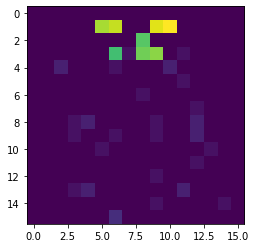

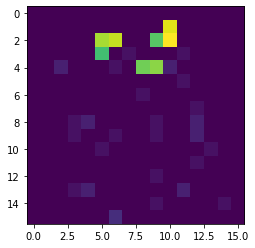

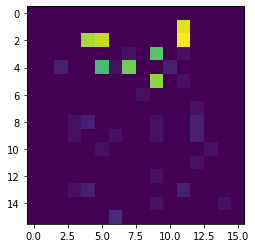

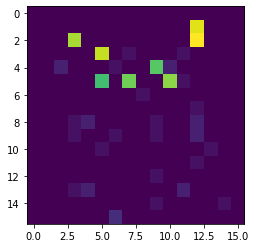

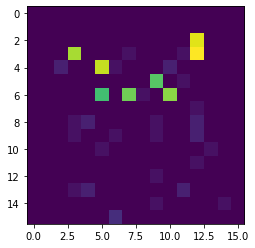

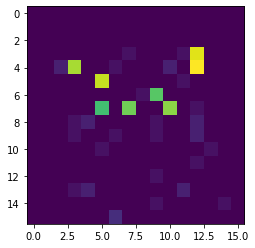

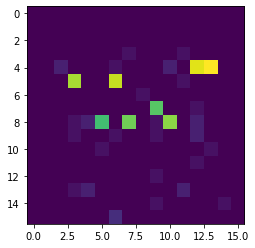

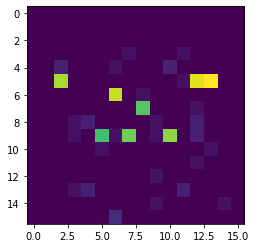

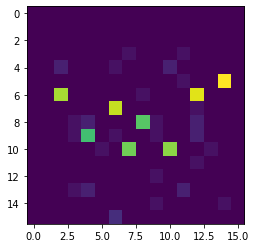

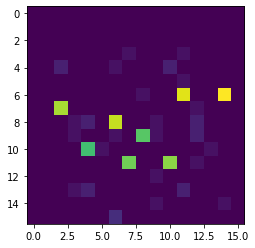

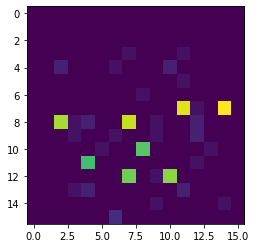

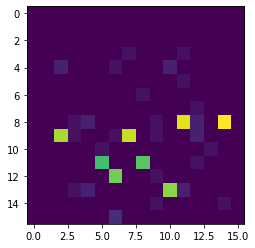

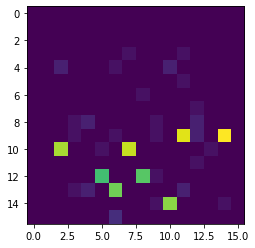

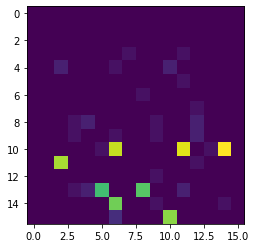

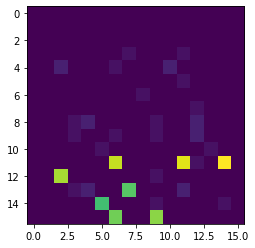

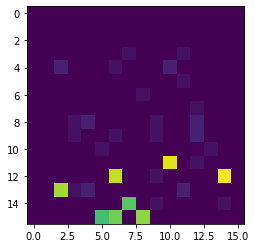

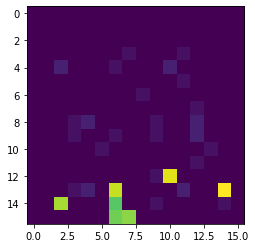

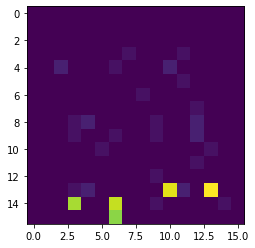

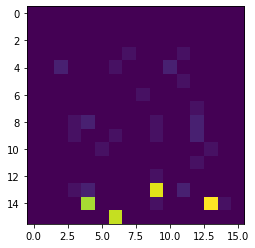

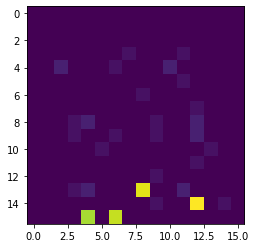

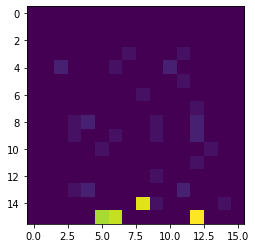

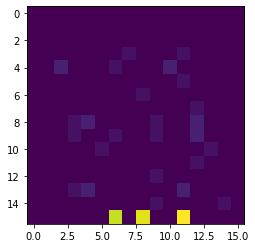

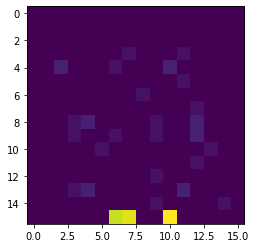

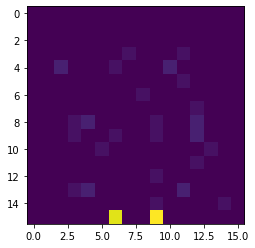

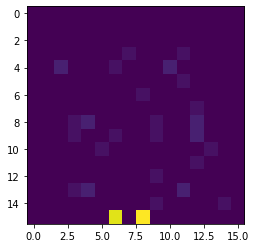

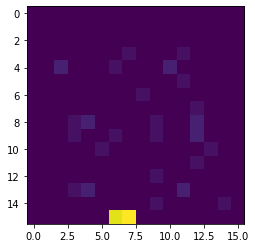

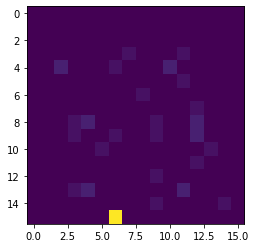

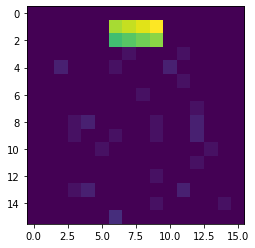

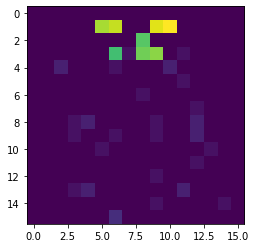

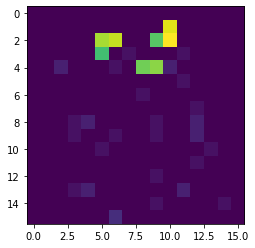

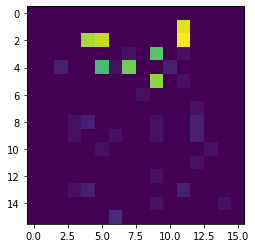

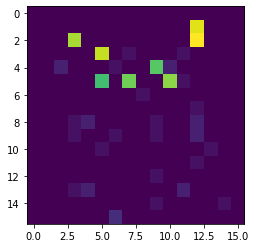

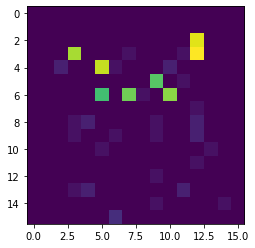

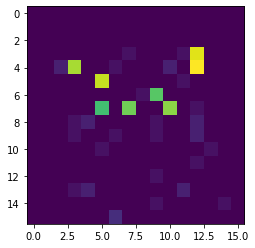

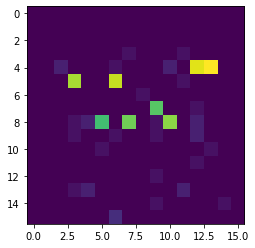

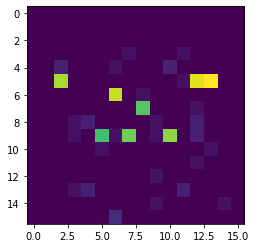

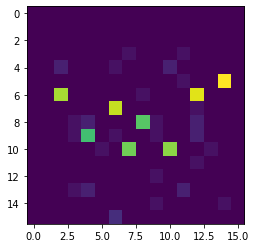

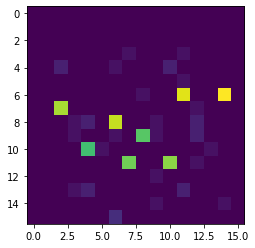

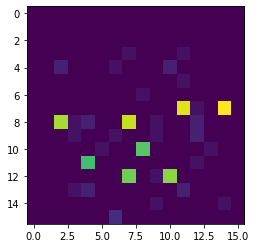

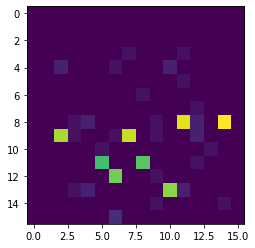

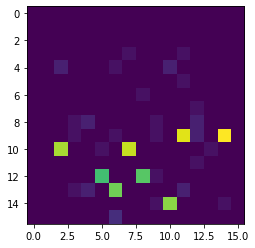

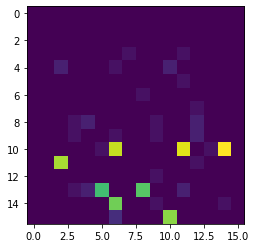

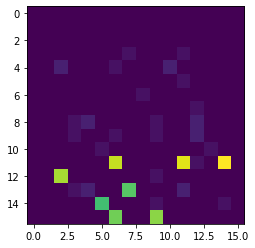

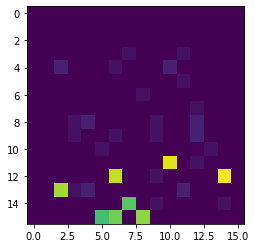

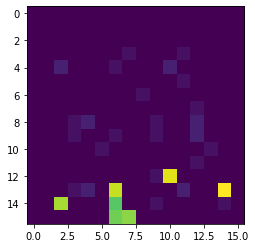

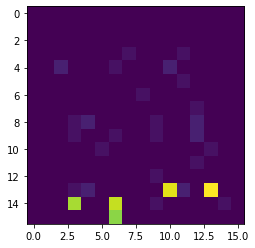

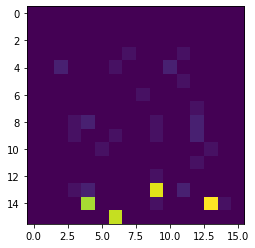

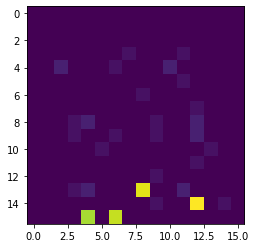

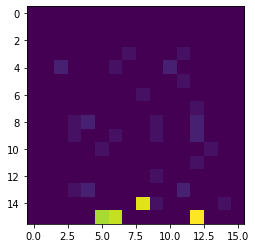

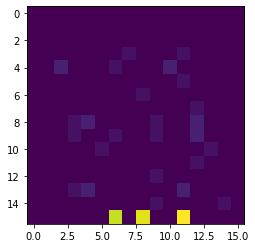

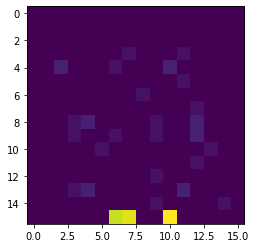

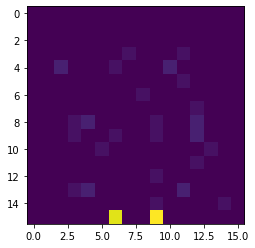

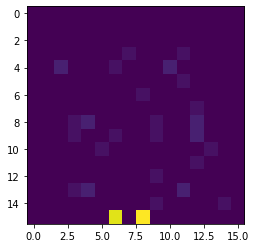

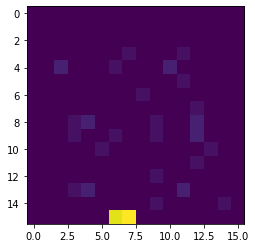

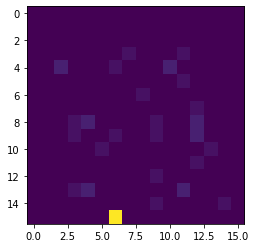

error: Couldn't open images/screenshot_0.png

In [14]:
mapp = np.array([
    "FFFFFFFFFFFFFFFF",
    "FFFFFFFFFFFFFFFF",
    "FFFFFFFFFFFFFFFF",
    "FFFFFFFHFFFHFFFF",
    "FFSFFFHFFFSFFFFF",
    "FFFFFFFFFFFHFFFF",
    "FFFFFFFFHFFFFFFF",
    "FFFFFFFFFFFFHFFF",
    "FFFHSFFFFHFFSFFF",
    "FFFHFFHFFHFFSFFF",
    "FFFFFHFFFFFFFHFF",
    "FFFFFFFFFFFFHFFF",
    "FFFFFFFFFHFFFFFF",
    "FFFHSFFFFFFSFFFF",
    "FFFFFFFFFHFFFFHF",
    "FFFFFFGFFFFFFFFF"
])

# Create an environment with the map and two agents
env = Environment(mapp,16, 8)

# Creation des agents avec des positions initiales aleatoires
#agents = [Agent(np.random.randint(env.size_map**2), np.random.randint(5), 0, False) for _ in range(env.number_agent)]

agents = [Agent(18+20,0,0, False),
          Agent(19+20,0,0,False),
          Agent(20+20,0,0, False),
          Agent(21+20,0,0, False),
          Agent(2+20,0,0, False),
          Agent(3+20,0,0, False),
          Agent(4+20,0,0, False),
          Agent(5+20,0,0,False)]

# Creation du jeu
game1 = Game(env, agents)



for step in range(2):
    
    done = [False]* env.number_agent
    terminated =  False
    State = np.zeros(env.number_agent)
    action = np.zeros(env.number_agent)
    nbSteps = 0


    episode_reward = [0]* env.number_agent

    for j in range(env.number_agent):
        game1.reset(game1.agents[j])
        #game.agents[0].state = np.random.randint(env.size_map**2)
    game1.reset_history()
    while (nbSteps <= 80 and (not terminated)):

        for  i in range(env.number_agent):
            
            pos = []
            State[i] = game1.agents[i].state
            pos_1 = env.position(State[i])
            pos_2 = np.zeros(len(pos_1))

            for j in range(env.number_agent):
                if i != j:

                    pos_2  += np.asarray(env.position(game1.agents[j].state))


            pos = (pos_1 + pos_2.tolist())
            #print((pos_2))
            rng = np.random.default_rng()

            if not(game1.agents[i].done): # look if agent1 is in a hole or got the reward
                 with torch.no_grad():
                    action[i] = loaded_networks[i][1].act(pos)
            else:
                 action[i] = 4 # rester sur place

        next_states, rewards, done = game1.step(action)

        nbSteps = nbSteps + 1

        terminated  = game1.game_over()
        game1.save_history()
        game1.display()

game1.render("rapport_gif")
        